In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from os import listdir
from songs import *  # songs.py is separate module for preprocessing midi

## Параметры модели

In [2]:
# periods of repetition we're going to search for
HISTORY_TIMES = np.array([4, 8, 16, 32, 48, 64, 96, 128])

# time (binary coded) as additional input 
TIME_AS_INPUT_SIZE = 6

# number of voices in polyphonic sampling scheme
VOICES = 5

In [3]:
# Network Parameters
num_input = 12 + TIME_AS_INPUT_SIZE         # dimension of one input at moment
num_hidden_local = 100                      # dimension of LSTM for local dependencies 
num_hidden_read = 100                       # dimension of LSTM for reading from history
num_hidden_aggreg = 130                     # dimension of aggregation layer
num_hidden_voicegen = 100                   # dimension of voices generation layer
num_output = 12                             # output dimension for each voice

num_hidden_decoder = 100                    # dimension of decoder LSTM
num_decoder_output = 88                     # dimension of decoder output
num_decoder_rbm_hidden = 36                 # dimension of decoder rbm hidden layer
rbm_k = 1                                   # Gibbs sampling iterations in decoder

## Модель

In [4]:
INDICES = Variable(torch.LongTensor(HISTORY_TIMES - 1))

class HistoryReader(nn.Module):
    '''Soft attention module'''
    def __init__(self):
        super(HistoryReader, self).__init__()
        
        self.read_lstm = nn.LSTM(num_input, num_hidden_read)        
        self.read_linear = nn.Linear(num_hidden_read, len(HISTORY_TIMES))
    
    def init_hidden(self, batch_size, history_init=None):
        self.hidden = (Variable(torch.zeros(1, batch_size, num_hidden_read)),
                       Variable(torch.zeros(1, batch_size, num_hidden_read)))
        
        # storing history of sequence, requires initialization
        self.history = history_init        
    
    def forward(self, x):        
        # getting coeff of weighted sum
        read_index, self.hidden = self.read_lstm(x, self.hidden)                
        read_index = F.softmax(self.read_linear(read_index), dim=2)
        self.read_index = read_index.data[0].numpy()        
        
        # updating history and selecting only ones with potential music periods
        self.history = torch.cat([x[0][:, None, :num_output], self.history[:, :-1]], dim=1)
        variants = torch.index_select(self.history, 1, INDICES)
        
        # calculating weighted sum
        read = torch.bmm(read_index[0,:,None], variants).squeeze(1)       
        
        return read[None]

In [5]:
class PolyphonySampler(nn.Module):
    '''Voice-based polyphony sampler'''
    def __init__(self):
        super(PolyphonySampler, self).__init__()
        
        # all voices are lstms, parameters shared
        self.lstm = nn.LSTM(num_hidden_aggreg + 2*num_output, num_hidden_voicegen)
        self.linear = nn.Linear(num_hidden_voicegen, 2*num_output)
        
    def init_hidden(self, batch_size):        
        self.hidden = []
        for i in range(VOICES):
            self.hidden.append((Variable(torch.zeros(1, batch_size, num_hidden_voicegen)),
                                Variable(torch.zeros(1, batch_size, num_hidden_voicegen))))
    
    def forward(self, x, next_x=None):
        # for storing decisions, which notes will play and which will not, and all probabilities
        sampled_notes = torch.zeros(1, x.size()[1], num_output)        
        sample_p = Variable(torch.zeros(1, x.size()[1], num_output))
        neg_sample_p = Variable(torch.ones(1, x.size()[1], num_output))
                                
        banned_notes = torch.zeros(1, x.size()[1], num_output)       
        ban_p = Variable(torch.zeros(1, x.size()[1], num_output))
        neg_ban_p = Variable(torch.ones(1, x.size()[1], num_output))
        
        # for visualisation
        self.voice_distributions = []
        self.voice_decisions = []
        
        for i in range(VOICES):
            # forward pass
            all_input = torch.cat([x, Variable(sampled_notes), Variable(banned_notes)], dim=2)
            out, self.hidden[i] = self.lstm(all_input, self.hidden[i])
            out = self.linear(out)            
            
            # outputs for notes, decisions for which is already made, must be zero
            coeff = (1 - torch.cat([sampled_notes, sampled_notes], dim=2)) * \
                    (1 - torch.cat([banned_notes, banned_notes], dim=2))
            out = Variable(coeff) * torch.exp(out)                       
            out = out / out.sum(2)[:,:,None]
            
            # storing the result
            self.voice_distributions.append(out.data[0].numpy())
            
            # probability to sample note is probability to sample it in previous voices plus to sample it in current voice
            sample_p = sample_p + neg_sample_p * out[:,:,:num_output]
            neg_sample_p = neg_sample_p * (1 - out[:,:,:num_output])  # probability of NOT to sample note
            
            # same thing for banning note
            ban_p = ban_p + neg_ban_p * out[:,:,num_output:]
            neg_ban_p = neg_ban_p * (1 - out[:,:,num_output:])
            
            # making decision (sampling)
            sample = torch.LongTensor(x.size()[1], 2*num_output).zero_()
            sample.scatter_(1, torch.multinomial(out.squeeze(0).data, 1), 1)
            
            self.voice_decisions.append(sample.numpy())
            
            # we require the ground truth as input to voices during learning phase
            if self.training:
                sample = torch.cat([(sample[:,:num_output] + sample[:,num_output:]) * next_x,
                                    (sample[:,:num_output] + sample[:,num_output:]) * (1 - next_x)], dim=1)
            
            # adding decision to final answer
            sampled_notes[0] += sample[:,:num_output].float()
            banned_notes[0]  += sample[:,num_output:].float()
        
        return sampled_notes, sample_p*(1 - ban_p)

In [6]:
import itertools
def time_generator():
    '''discrete time'''
    times = [np.array(t) for t in itertools.product([0, 1], repeat=TIME_AS_INPUT_SIZE)]
    t = 0
    
    while True:
        yield torch.FloatTensor(times[t])
        t = (t + 1) % len(times)

In [7]:
class Model(nn.Module):
    '''generator
    consists of parallel LSTM and HistoryUser as first layer and LSTM as second layer
    output is sent to polyphonic sampler'''
    def __init__(self):
        super(Model, self).__init__()
        
        self.local_lstm = nn.LSTM(num_input, num_hidden_local)
        self.history_reader = HistoryReader()
        self.aggregation_lstm = nn.LSTM(num_output + num_hidden_local, num_hidden_aggreg)
        self.sampler = PolyphonySampler()
        
        self.init_hidden(1, None)
        
    def init_hidden(self, batch_size, history_init): 
        self.timer = time_generator()
        
        self.local_hidden = (Variable(torch.zeros(1, batch_size, num_hidden_local)),
                             Variable(torch.zeros(1, batch_size, num_hidden_local)))
        
        self.history_reader.init_hidden(batch_size, history_init)
        
        self.aggreg_hidden = (Variable(torch.zeros(1, batch_size, num_hidden_aggreg)),
                             Variable(torch.zeros(1, batch_size, num_hidden_aggreg)))
        
        self.sampler.init_hidden(batch_size)
    
    def forward(self, x, next_x=None):            
        inp = torch.cat([x, Variable(self.timer.__next__())[None, None].repeat(1, x.size()[1], 1)], dim=2)
        
        local_out, self.local_hidden = self.local_lstm(inp, self.local_hidden)            
        read = self.history_reader(inp)     
        
        out, self.aggreg_hidden = self.aggregation_lstm(torch.cat([local_out, read], dim=2), self.aggreg_hidden)
        
        return self.sampler(out, next_x)

In [8]:
class Decoder(nn.Module):
    '''decoder and velocity generator'''
    def __init__(self):
        super(Decoder, self).__init__()
        
        #LSTM-RBM as decoder
        self.decoder_lstm = nn.LSTM(num_output + num_decoder_output, num_hidden_decoder)
        self.v_bias_linear = nn.Linear(num_hidden_decoder, num_decoder_output) 
        self.h_bias_linear = nn.Linear(num_hidden_decoder, num_decoder_rbm_hidden)      
        
        #stationar parameter of RBM
        self.W = nn.Parameter(torch.randn(num_decoder_rbm_hidden, num_decoder_output)*1e-2)
        
        #velocity generated by LSTM
        self.velocity_lstm = nn.LSTM(num_output + num_decoder_output, num_hidden_decoder)  
        self.velocity_linear = nn.Linear(num_hidden_decoder, num_decoder_output)   
        
        self.init_hidden(1)
        
    def init_hidden(self, batch_size):        
        self.decoder_hidden = (Variable(torch.zeros(1, batch_size, num_hidden_decoder)),
                               Variable(torch.zeros(1, batch_size, num_hidden_decoder)))
        self.velocity_hidden = (Variable(torch.zeros(1, batch_size, num_hidden_decoder)),
                               Variable(torch.zeros(1, batch_size, num_hidden_decoder)))
    
    # so it was done in one of rbm realisations...
    # seems legit, though akward.
    def sample_from_p(self, p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    # for optimization during learning
    def free_energy(self, v, v_bias, h_bias):
        vbias_term = (v * v_bias).sum(2)
        hidden_term = (v.bmm(self.W.t()[None]) + h_bias).exp().add(1).log().sum(2)
        return (-hidden_term - vbias_term).mean()
    
    def forward(self, x, prev_x_decoded):            
        inp = torch.cat([x, prev_x_decoded], dim=2)
        
        out, self.decoder_hidden = self.decoder_lstm(inp, self.decoder_hidden) 
        vel, self.velocity_hidden = self.velocity_lstm(inp, self.velocity_hidden)
        
        return F.sigmoid(self.velocity_linear(vel)), self.v_bias_linear(out), self.h_bias_linear(out)
    
    # Gibbs sampling from RBM
    def sample(self, _v, v_bias, h_bias):
        v = _v
        
        for _ in range(rbm_k):
            p_h = F.sigmoid(v.bmm(self.W.t()[None]) + h_bias)
            h = self.sample_from_p(p_h)
            
            p_v = F.sigmoid(h.bmm(self.W[None]) + v_bias)
            v = self.sample_from_p(p_v)
        return v, p_v

In [9]:
def forward_pass(model, decoder, batch_x, batch_history_init, batch_decoded):
    '''learning process for all models'''
    
    # initialization
    model.init_hidden(batch_x.shape[1], Variable(torch.FloatTensor(batch_history_init)))
    decoder.init_hidden(batch_x.shape[1])
    
    # transforming data to torch format
    batch_x = Variable(torch.FloatTensor(batch_x))
    batch_binary_decoded = Variable(torch.FloatTensor((batch_decoded > 0).astype(np.float32)))
    batch_decoded = Variable(torch.FloatTensor(batch_decoded)) / 128
    
    # storing required probabilities and additional info
    basic_p = Variable(torch.FloatTensor(batch_x.shape[0] - 1, batch_x.shape[1], num_output)).zero_()
    decoder_p = Variable(torch.FloatTensor(batch_x.shape[0] - 1, batch_x.shape[1], num_decoder_output)).zero_()
    velocity = Variable(torch.FloatTensor(batch_x.shape[0] - 1, batch_x.shape[1], num_decoder_output)).zero_()
    read_index, voice_distributions, voice_decisions = [], [], []
    decoder_loss = Variable(torch.FloatTensor(1).zero_())
    
    for t in range(len(batch_x)-1):
        # forward pass
        _, basic_p[t] = model(batch_x[t][None], batch_x[t+1].data.long())        
        velocity[t], v_bias, h_bias = decoder(batch_x[t + 1][None], batch_decoded[t][None])
        
        # contrastive divergence algorithm for RBM
        v = batch_binary_decoded[t+1][None]
        v1, vp = decoder.sample(v, v_bias, h_bias)
        decoder_p[t] = vp[0]
        v1 *= batch_x[t+1][None].repeat(1, 1, 1 + num_decoder_output // num_output)[:,:,:num_decoder_output]
        decoder_loss += decoder.free_energy(v, v_bias, h_bias) - decoder.free_energy(v1, v_bias, h_bias)
        
        # storing additional info
        read_index.append(model.history_reader.read_index)
        voice_distributions.append(model.sampler.voice_distributions)
        voice_decisions.append(model.sampler.voice_decisions)
    
    # calculating loss
    loss = -(batch_x[1:] * torch.log(basic_p) + (1 - batch_x[1:])*torch.log(1 - basic_p))
    velocity_loss = batch_binary_decoded[1:] * (velocity - batch_decoded[1:])**2
    decoder_loss /= (batch_x.shape[0] - 1)
    
    # returns: losses (Variable), info (numpy)
    # info is: numbers, losses for this batch
    #          losses pictures for generator, decoder probabilities for decoder, and velocity outputs
    #          additionally: what HistoryUser reads, distributions and decisions for each of 5 voices
    return (loss.sum(dim=2).mean(), velocity_loss.mean(), decoder_loss), \
           (loss.sum(dim=2).mean().data.numpy()[0], velocity_loss.mean().data.numpy()[0], decoder_loss.data.numpy()[0], 
            loss.data.numpy(), decoder_p.data.numpy(), velocity.data.numpy(),
            np.array(read_index), np.array(voice_distributions), np.array(voice_decisions))

def learn(model, decoder, batch_x, batch_history_init, batch_decoded, optimizer, decoder_optimizer):
    model.train()
    decoder.train()
    optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    losses, info = forward_pass(model, decoder, batch_x, batch_history_init, batch_decoded)
    
    for loss in losses:
        loss.backward()
    
    optimizer.step()
    decoder_optimizer.step()
   
    return info

def test(model, decoder, batch_x, batch_history_init, batch_decoded):    
    model.train()
    decoder.train()
    
    losses, info = forward_pass(model, decoder, batch_x, batch_history_init, batch_decoded)
    
    return info

def sample(model, decoder, start, decoder_start, time_limit):
    '''generation from model'''
    
    # initialization
    model.init_hidden(1, Variable(torch.zeros(1, int(HISTORY_TIMES.max()), num_output)))
    decoder.init_hidden(1)
    model.eval()
    decoder.eval()
    
    # forward pass through seed
    sample = [start[0]]
    decoded_sample = [decoder_start[0] / 128.]
    
    for t in range(len(start)-1):
        inp = Variable(torch.FloatTensor(start[t])[None, None])
        next_notes, _ = model(inp)
        
        decoder_inp = Variable(torch.FloatTensor(start[t+1])[None, None]), \
                      Variable(torch.FloatTensor(decoder_start[t+1] / 128.)[None, None])
        decoder(*decoder_inp)
        
        sample.append(start[t+1])
        decoded_sample.append(decoder_start[t+1] / 128.)
    
    next_notes = torch.FloatTensor(start[-1][None, None])
    
    # generation cycle
    while len(sample) < time_limit:
        # in 12-notes representation
        next_notes, _ = model(Variable(next_notes))        
        sample.append(next_notes[0][0].numpy())
        
        # decoding
        prev_decoded = Variable(torch.FloatTensor((decoded_sample[-1] > 0).astype(np.float32))[None, None])
        velocity, v_bias, h_bias = decoder(Variable(next_notes), prev_decoded)
        next_decoded, _ = decoder.sample(prev_decoded, v_bias, h_bias)
        
        # generating velocity and applying 12-notes mask
        mask = np.tile(sample[-1], (1 + num_decoder_output // num_output))[:num_decoder_output]
        velocity = velocity[0][0].data.numpy()
        velocity[np.logical_not(mask * next_decoded[0][0].data.numpy())] = 0
        decoded_sample.append(velocity)
        
    return np.array(sample), (128*np.array(decoded_sample)).astype(int)

### Графика

In [12]:
plt.rcParams.update({'font.size': 16})
def drawNotes(song, name="", scale=(None, None)):
    if scale[0] is None:
        scale = (song.shape[0] / 10, song.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.title(name)
    plt.imshow(song.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.shape[0], 8))
    plt.show()

## Данные для обучения

In [ ]:
# creating dataset from MIDI files
songs = np.array([song.notes for song in [Song("data\\" + DatasetName + "\\" + name)
                             for name in listdir("data\\" + DatasetName) if name[-4:] == ".mid"] if song.correct])

In [3]:
# OR from stored numpy files
songs = np.append(np.load("Greats1_dataset.npy"), np.load("Greats2_dataset.npy"))

In [12]:
batch_size = 140
fragment_lentgh = 256
fragment_step = 32

In [16]:
def compress(song):
    '''compressing in 12-notes representation'''
    compressed = song[:, :12] > 0
    for i in range(1,7):
        compressed = np.logical_or(compressed, song[:, 12*i:12*i+12] > 0)            
    return compressed

In [14]:
song_fragments = []    # 88-notes representation
csong_fragments = []   # 12-notes representation
history_inits = []     # seeds for HistoryUser

for song in songs:
    csong = compress(song)
    
    history = np.zeros((HISTORY_TIMES.max(), 12))
    
    for i in range(0, csong.shape[0] - fragment_lentgh, fragment_step):
        song_fragments.append(song[i:i+fragment_lentgh])
        csong_fragments.append(csong[i:i+fragment_lentgh])
        
        history_inits.append(history.copy())        
        history = np.vstack([csong[i:i+fragment_step][::-1], history[fragment_step:]])

song_fragments = np.array(song_fragments)
csong_fragments = np.array(csong_fragments)
history_inits = np.array(history_inits)

print("Dataset size: ", len(song_fragments))

Dataset size:  48427


In [15]:
TRAIN_TEST_SPLIT = 40000

In [16]:
def batchGenerator(test=False):
    while True:
        # choosing batch from set of fragments
        if test:
            indexes = np.random.choice(np.arange(TRAIN_TEST_SPLIT, len(csong_fragments)), batch_size)
        else:            
            indexes = np.random.choice(np.arange(TRAIN_TEST_SPLIT), batch_size)
            
        batch_x, batch_history_init, batch_decoded = csong_fragments[indexes], history_inits[indexes], song_fragments[indexes]
        
        # augmentation: random cyclic shift
        to_roll = np.random.randint(-6, 6)
        if to_roll > 0:
            batch_decoded[:, :, -to_roll:] = 0
        else:
            batch_decoded[:, :, :-to_roll] = 0

        batch_x = np.roll(batch_x, to_roll, axis=2)
        batch_history_init = np.roll(batch_history_init, to_roll, axis=2)
        batch_decoded = np.roll(batch_decoded, to_roll, axis=2)
        
        # preparing to be input to neural nets
        yield np.moveaxis(batch_x, 1, 0).astype(np.float32), \
              batch_history_init.astype(np.float32), \
              np.moveaxis(batch_decoded, 1, 0).astype(np.float32)

# Обучение

In [55]:
model = Model()
decoder = Decoder()

In [56]:
#model.load_state_dict(torch.load("Greats - model.pt"))
#decoder.load_state_dict(torch.load("Greats - decoder.pt"))

In [23]:
losses = []
decoder_losses = []
velocity_losses = []

test_gener = batchGenerator(test=True)
test_losses = []
test_decoder_losses = []
test_velocity_losses = []

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.1, eps=1e-4)
last_save = -1

for batch_x, batch_history_init, batch_decoded in batchGenerator():
    
    loss, velocity_loss, decoder_loss, loss_picture, decoder_p, velocity, read_index, voice_probas, voice_decisions = \
        learn(model, decoder, batch_x, batch_history_init, batch_decoded, optimizer, decoder_optimizer)
           
    if len(losses) % 50 == 0:
        drawNotes(loss_picture[:, 0], "Loss")
        print("Loss: ", loss)
        
        if len(losses) % 200 == 0:
            drawNotes(read_index[:, 0], "Reading From History")
            
            decisions = np.zeros_like(voice_decisions[:, 0, 0, :12])
            for i in range(VOICES):
                drawNotes(voice_probas[:, i, 0], "Voice " + str(i))
                decisions += voice_decisions[:, i, 0, :12]
                decisions -= voice_decisions[:, i, 0, 12:]
            
            drawNotes(decisions, "Decisions made")
            
            drawNotes(decoder_p[:, 0], "Decoder Probas")
            
            drawNotes(velocity[:, 0], "Velocity")
        
    losses.append(loss)
    decoder_losses.append(decoder_loss)
    velocity_losses.append(velocity_loss)
    
    if len(losses) % 50 == 1:
        batch_x, batch_history_init, batch_decoded = test_gener.__next__()
        
        loss, velocity_loss, decoder_loss, loss_picture, decoder_p, velocity, read_index, voice_probas, voice_decisions = \
            test(model, decoder, batch_x, batch_history_init, batch_decoded)
        
        drawNotes(loss_picture[:, 0], "Loss (Test)")        
        print("Test Loss: ", loss)
    
        test_losses.append(loss)
        test_decoder_losses.append(decoder_loss)
        test_velocity_losses.append(velocity_loss)
        
        if len(losses) % 200 == 1:
            drawNotes(read_index[:, 0], "Reading From History (Test)")
            
            decisions = np.zeros_like(voice_decisions[:, 0, 0, :12])
            for i in range(VOICES):
                drawNotes(voice_probas[:, i, 0], "Voice " + str(i) + " (Test)")
                decisions += voice_decisions[:, i, 0, :12]
                decisions -= voice_decisions[:, i, 0, 12:]
            
            drawNotes(decisions, "Decisions made (Test)")
            
            drawNotes(decoder_p[:, 0], "Decoder Probas (Test)")
            
            drawNotes(velocity[:, 0], "Velocity (Test)")
            
            if test_losses[-1] == np.array(test_losses).min():
                if not loss is None:
                    torch.save(model.state_dict(), "Greats - model.pt")
                if not decoder_p.mean() is None:
                    torch.save(decoder.state_dict(), "Greats - decoder.pt")
                last_save = len(losses)

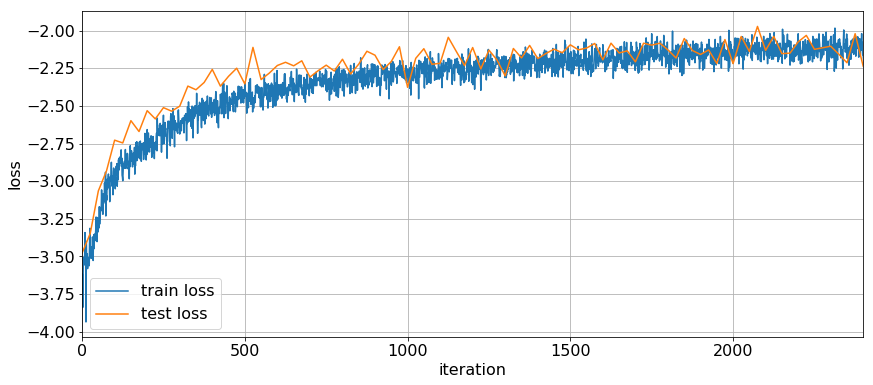

In [415]:
plt.figure(figsize=(14, 6))
plt.plot(-losses, label="train loss")
plt.plot(np.arange(len(test_losses))*25, -test_losses, label="test loss")
plt.xlim([0, 2400])
plt.ylabel("loss")
plt.xlabel("iteration")
plt.grid()
plt.legend()

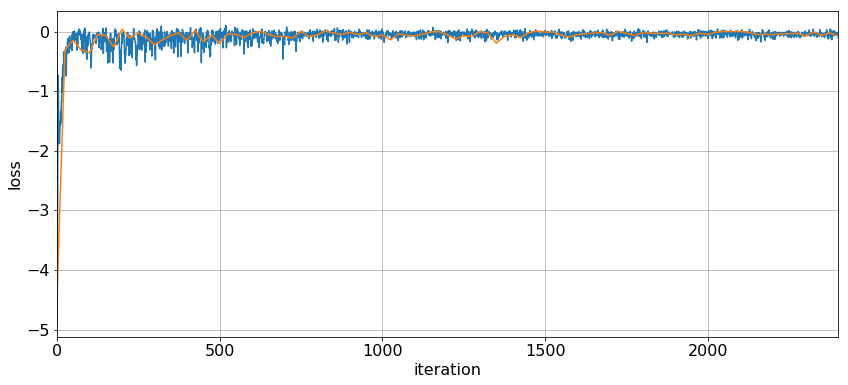

In [416]:
plt.figure(figsize=(14, 6))
plt.plot(-decoder_losses)
plt.plot(np.arange(len(test_decoder_losses))*25, -test_decoder_losses)
plt.xlim([0, 2400])
plt.ylabel("loss")
plt.xlabel("iteration")
plt.grid()
plt.legend()

## Генерируем

In [13]:
# loading model
model = Model()
decoder = Decoder()

model.load_state_dict(torch.load("Greats - model.pt"))
decoder.load_state_dict(torch.load("Greats - decoder.pt"))

In [14]:
seeds = np.load("seeds.npy")

In [17]:
seed = seeds[np.random.randint(0, len(seeds))]
cgen, gen = sample(model, decoder, compress(seed).astype(np.float32), seed.astype(np.float32), 256)

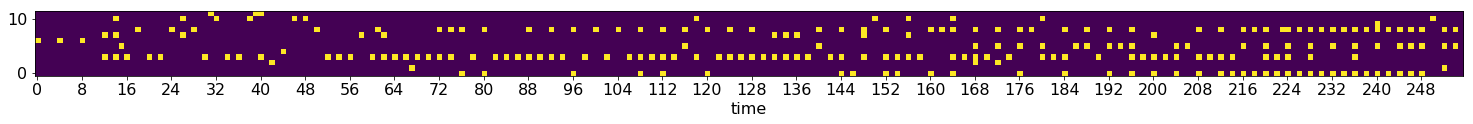

In [19]:
drawNotes(cgen)  # 12-dimensional representation

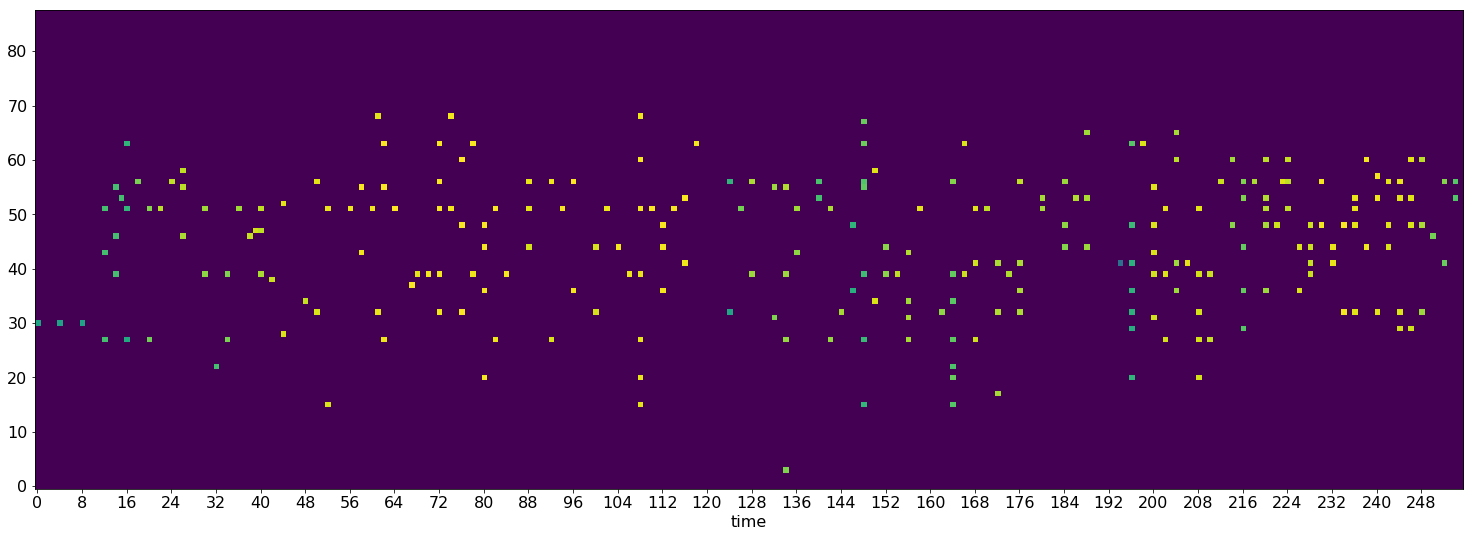

In [20]:
drawNotes(gen)  # 88-dimensional representation

In [22]:
Song(gen, finished=True).play()

### производство часа музыки

In [479]:
final_ans = np.zeros((0, 88))
for _ in range(120):
    n = np.random.randint(0, len(songs))  # random seed (not included in final sample)
    _, gen = sample(model, decoder, compress(songs[n][:16]).astype(np.float32), songs[n][:16].astype(np.float32), 256)
    
    final_ans = np.vstack([final_ans, gen[16:], np.zeros((24, 88))])

In [480]:
final_ans = final_ans[:28760]  # CrowdAI Challenge requires 1 hour precisely

In [488]:
Song(final_ans.astype(int), finished=True).save_file("Final Model 1h")